# Simplicial Interpolation on Synthetic logistic Data

This notebook evaluates simplicial interpolation methods on synthetic binary classification data generated from logistic regression on Gaussian features. The analysis compares a hybrid simplicial classifier against standard 1-Nearest Neighbor across varying dimensions and noise levels.

## Overview

The notebook implements a **Local Simplicial Classifier** that attempts simplicial interpolation within convex hulls of k-nearest neighbors, falling back to 1-NN when points lie outside any hull. This hybrid approach combines the smoothness of interpolation with the robustness of nearest neighbor methods.

## Goals

- **Hybrid Classification**: Simplicial interpolation with 1-NN fallback
- **Synthetic Data**: Logistic regression on Gaussian features with controllable label noise
- **Comprehensive Evaluation**: Systematic testing across dimensions (3-8) and noise levels (0-30%)
- **Statistical Robustness**: Multiple random seeds for reliable results
- **Performance Comparison**: Error rates and coverage analysis

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import linprog


class KNNClassifier:
    """Standard 1-NN Classifier"""
    def __init__(self, k=1):
        self.k = k
        self.nn = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        return self

    def predict(self, X):
        X = np.asarray(X)
        # Find closest neighbor
        _, idxs = self.nn.kneighbors(X)
        return self.y_train[idxs[:, 0]]

class LocalSimplicialClassifier:
    """
    Hybrid Simplicial Classifier:
    1. Tries to interpolate using Linear Programming (LP).
    2. If point is OUTSIDE hull (LP fails), falls back to 1-NN.
    """
    def __init__(self, k=15):
        self.k = int(k)
        self.nn = None
        self.X_train = None
        self.y_train = None
        self.coverage_rate_ = 0.0

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        return self

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples, dtype=int)
        success_count = 0
        
        c = np.zeros(self.k)
        bounds = [(0, None) for _ in range(self.k)]
        
        dists, idxs = self.nn.kneighbors(X)
        
        print(f"Solving LP for {n_samples} points...", end="\r")
        
        for i in range(n_samples):
            local_idx = idxs[i]
            X_loc = self.X_train[local_idx]
            y_loc = self.y_train[local_idx]
            
            A_eq = np.vstack([X_loc.T, np.ones((1, self.k))])
            b_eq = np.concatenate([X[i], [1.0]])
            
            res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
            
            if res.success:
                w = res.x
                score = np.dot(w, y_loc)
                y_pred[i] = 1 if score >= 0.5 else 0
                success_count += 1
            else:
                y_pred[i] = y_loc[0]
                
        self.coverage_rate_ = success_count / n_samples
        return y_pred

## Synthetic Data Generation

This cell defines the `make_logistic_gaussian_data` function for generating synthetic binary classification datasets.

### Data Model
- **Features**: X ~ N(0, I_d) - Standard multivariate Gaussian in d dimensions
- **Teacher Vector**: u ~ N(0, I_d), normalized to unit length
- **Clean Labels**: P(y=1|x) = σ(γ * (x·u)) where σ is the sigmoid function
- **Noisy Labels**: Independent flips with probability p_noise

### Key Properties
- **Noise Control**: Allows systematic study of label noise effects
- **Scalability**: Efficient generation for large n and d

In [10]:
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

def make_logistic_gaussian_data(n, d, gamma=2.0, p_noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.normal(0.0, 1.0, size=(n, d))
    
    # Dense teacher vector
    u = rng.normal(0.0, 1.0, size=d)
    u /= np.linalg.norm(u)
    
    eta = sigmoid(gamma * (X @ u))
    y_clean = (rng.random(n) < eta).astype(int)
    
    # Add noise
    y = y_clean.copy()
    flips = rng.random(n) < p_noise
    y[flips] = 1 - y[flips]
    
    return X, y, y_clean



## Comprehensive Dimension vs Noise Experiment

This cell executes the main experimental evaluation, systematically comparing simplicial interpolation against 1-NN across multiple dimensions and noise levels with statistical averaging.

### Experimental Design
- **Dimensions**: d ∈ {3,4,5,6,7,8}
- **Noise Levels**: p ∈ {0.0, 0.05, 0.1, 0.2, 0.3}
- **Random Seeds**: 5 different seeds for statistical robustness
- **Dataset Size**: 30,000 training samples, 200 test samples per trial
- **k_neighbors**: 3×d (scales with dimensionality)

### Methodology
For each combination of (d, p, seed):
1. **Generate Data**: Create training data with noise p, clean test data (p=0)
2. **Train Models**:
   - 1-NN: Standard nearest neighbor
   - Simplicial: Hybrid interpolation with 1-NN fallback
3. **Evaluate**: Measure error rates and coverage on test set
4. **Aggregate**: Average across 5 seeds for each (d, p) combination

### Metrics Collected
- **1-NN Error**: Classification error of 1-nearest neighbor
- **Simplicial Error**: Error of hybrid simplicial classifier
- **Coverage**: Fraction of test points inside simplicial hulls

### Results Visualization
6-subplot grid (2×3) showing error vs noise curves:
- **Red circles (1-NN)**: 1-Nearest Neighbor error rates
- **Blue squares (Simplicial)**: Hybrid classifier error rates
- **X-axis**: Training label noise (0-30%)
- **Y-axis**: Test error rate (0-1)
- **Titles**: Include average simplicial coverage for each dimension


Running Experiment across dimensions [3, 5, 7, 9, 11, 13]...

Processing Dimension d=3 (k=9)...
  Noise 0.00 -> 1NN: 0.698, Simp: 0.730 (Cov: 85.00%)
  Noise 0.05 -> 1NN: 0.684, Simp: 0.703 (Cov: 85.00%)
  Noise 0.10 -> 1NN: 0.666, Simp: 0.694 (Cov: 85.00%)
  Noise 0.20 -> 1NN: 0.624, Simp: 0.646 (Cov: 85.00%)
  Noise 0.30 -> 1NN: 0.581, Simp: 0.586 (Cov: 85.00%)

Processing Dimension d=5 (k=15)...
  Noise 0.00 -> 1NN: 0.710, Simp: 0.743 (Cov: 78.10%)
  Noise 0.05 -> 1NN: 0.685, Simp: 0.725 (Cov: 78.10%)
  Noise 0.10 -> 1NN: 0.659, Simp: 0.712 (Cov: 78.10%)
  Noise 0.20 -> 1NN: 0.629, Simp: 0.673 (Cov: 78.10%)
  Noise 0.30 -> 1NN: 0.602, Simp: 0.611 (Cov: 78.10%)

Processing Dimension d=7 (k=21)...
  Noise 0.00 -> 1NN: 0.681, Simp: 0.703 (Cov: 51.20%)
  Noise 0.05 -> 1NN: 0.658, Simp: 0.683 (Cov: 51.20%)
  Noise 0.10 -> 1NN: 0.638, Simp: 0.669 (Cov: 51.20%)
  Noise 0.20 -> 1NN: 0.609, Simp: 0.642 (Cov: 51.20%)
  Noise 0.30 -> 1NN: 0.564, Simp: 0.604 (Cov: 51.20%)

Processing Dimension 

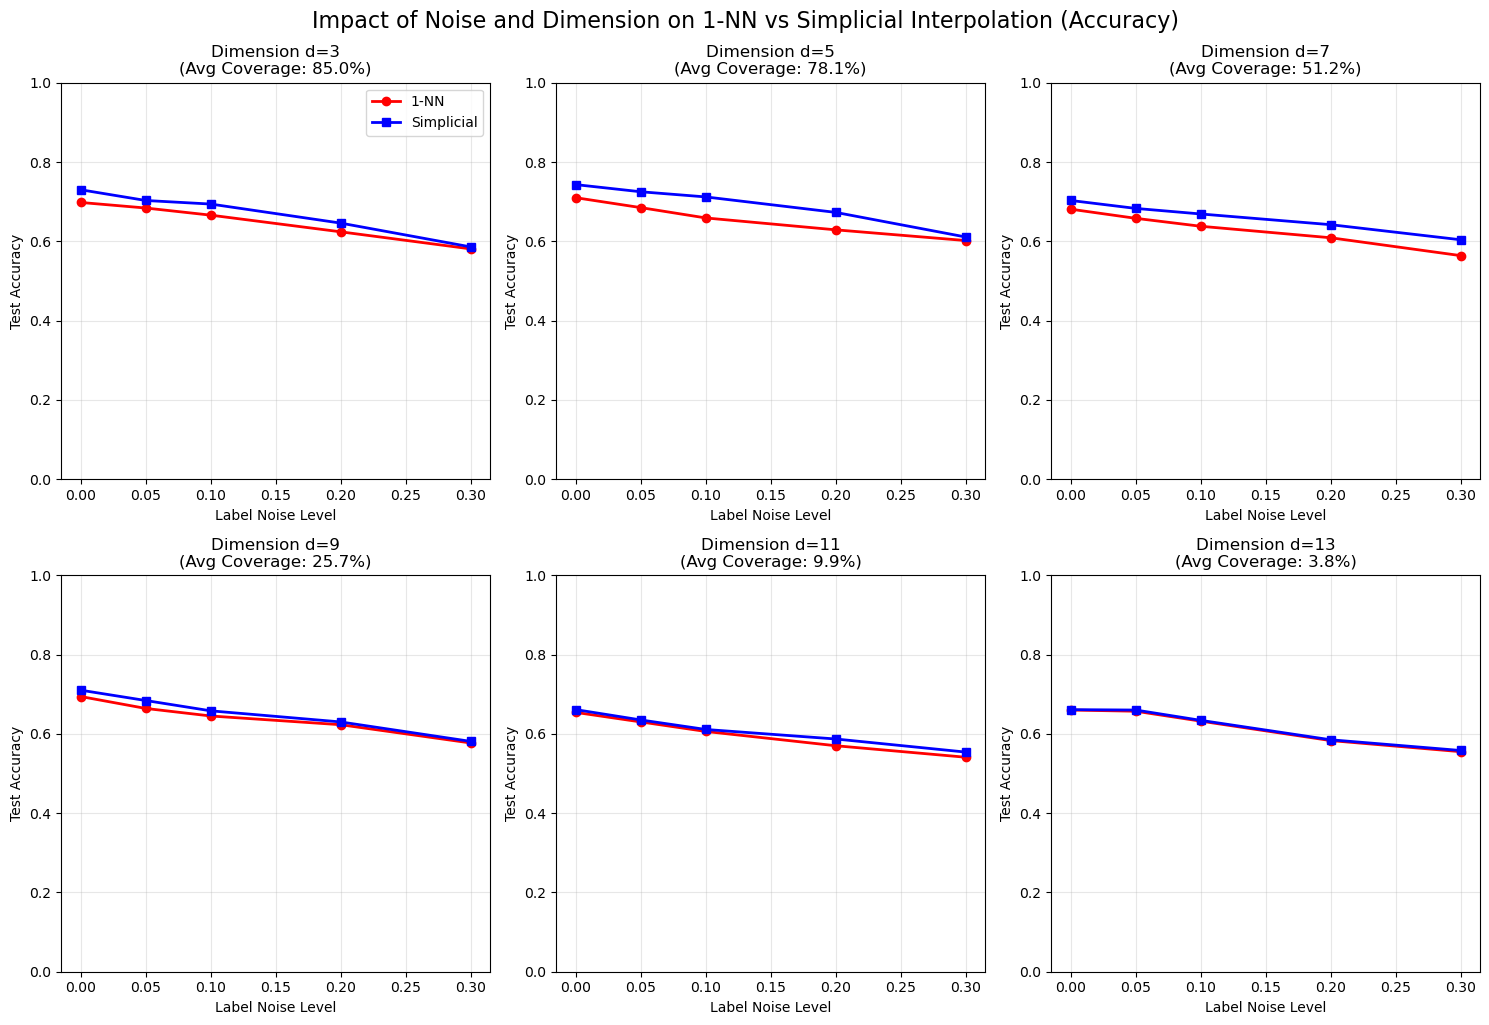

In [11]:
d_values = range(3, 14, 2)
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = range(5)

n_train = 300000
n_test = 200

results = {}

print(f"Running Experiment across dimensions {list(d_values)}...")

for d in d_values:
    results[d] = {'noise': [], '1nn_acc': [], 'simp_acc': [], 'cov': []}
    
    k_simplicial = d * 3
    
    print(f"\nProcessing Dimension d={d} (k={k_simplicial})...")
    
    for noise in noise_levels:
        temp_1nn = []
        temp_simp = []
        temp_cov = []
        
        for s in seeds:
            X_total, y_noisy_total, y_clean_total = make_logistic_gaussian_data(
                n_train + n_test, d, gamma=2.0, p_noise=noise, seed=s
            )
            
            Xtr = X_total[:n_train]
            ytr = y_noisy_total[:n_train]
            
            Xte = X_total[n_train:]
            yte = y_clean_total[n_train:]
            
            m1 = KNNClassifier(k=1).fit(Xtr, ytr)
            temp_1nn.append(np.mean(m1.predict(Xte) == yte))
            
            ms = LocalSimplicialClassifier(k=k_simplicial).fit(Xtr, ytr)
            temp_simp.append(np.mean(ms.predict(Xte) == yte))
            temp_cov.append(ms.coverage_rate_)
            
        results[d]['noise'].append(noise)
        results[d]['1nn_acc'].append(np.mean(temp_1nn))
        results[d]['simp_acc'].append(np.mean(temp_simp))
        results[d]['cov'].append(np.mean(temp_cov))
        
        print(f"  Noise {noise:.2f} -> 1NN: {np.mean(temp_1nn):.3f}, Simp: {np.mean(temp_simp):.3f} (Cov: {np.mean(temp_cov):.2%})")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, d in enumerate(d_values):
    ax = axes[i]
    data = results[d]
    
    ax.plot(data['noise'], data['1nn_acc'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['simp_acc'], 'b-s', label='Simplicial', linewidth=2)
    
    avg_coverage = np.mean(data['cov'])
    ax.set_title(f"Dimension d={d}\n(Avg Coverage: {avg_coverage:.1%})")
    
    ax.set_xlabel("Label Noise Level")
    ax.set_ylabel("Test Accuracy")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle("Impact of Noise and Dimension on 1-NN vs Simplicial Interpolation (Accuracy)", y=1.02, fontsize=16)
plt.show()